# Plane Wave Fitting for Slowness Estimation
30th November,2021


plane wave fitting by iterating over all possible values of phi

In [4]:
# importing the requiered libraries

import numpy as np
import matplotlib.pyplot as plt
from sympy import *
import random


##### initialize no. of receivers, apparent horizontal velocity of sound, max frequency of source 

In [5]:
n_rec=11# number of receivers, to be kept odd for first run

rec_pos_act= np.zeros(shape =(n_rec,2))  # Assigning thr actual receiver position

v = 200 # m/s ### velocity of propagation (in sand)
freq=2 #Hz, max recorded frequency
lamda=v/freq# wavelength
d=2000#m,  l=2000m  > 10 times lamda 

##### initialize position of source and  receivers 

In [6]:
#setting source configuration randomly

a=random.randrange(d-d/10,d*5) # sourec distance must be more than or equal to d , limits set here are arbitary within this acceptance
b=random.randrange(d-d/10,d*5)
src=(b,a)
random.randrange(d-d/10,d*5)


#setting different receiver configurations

#uncomment following line for random distribution
rec_pos_act=np.random.normal(0,100,size=(n_rec,2))


#uncomment following line for linear distribution
for i in range(0,n_rec):
    rec_pos_act[i,1]=0
    rec_pos_act[i,0]=(i-(n_rec-1)/2)*5 #first receievr at (-50,0) last at (50,0), all in line, distance 5 between them 

#uncomment following line for circular distribution    
for i in range(0,n_rec):
    rec_pos_act[i,0]=100*cos(i*2*np.pi/n_rec)
    rec_pos_act[i,1]=100*sin(i*2*np.pi/n_rec) 




initialize time recordings by time of arrival, introduce noise in time and position

In [7]:


t_rec_ideal = np.zeros(shape =(n_rec,))  # time recorded in each receiver; form: (index of receiver,time) 


t_noise=np.random.normal(0,5/(v),size=(n_rec,))

#introduce noise in position
rec_pos_noise=np.random.normal(0,1,size=(n_rec,2))

rec_pos_mes= rec_pos_act + rec_pos_noise  # rec_pos_mes stores[(x1,y1),(x2,y2),..] 



#initialising time recordings

for i in range (0,n_rec):
    t_rec_ideal[0:n_rec] = np.sqrt((rec_pos_mes[0:n_rec,0]-src[0])**2 + (rec_pos_mes[0:n_rec,1]-src[1])**2)/v



### t_Rec_real has form [[rec1 recording], [rec2 recording]]

# introduce noise in time
t_Rec_real=t_rec_ideal + t_noise


# time difference between time recordings wrt receiver 1st rec, 
#in the form : time recorded by receiver at ith position - time recorded by 1st receiver 
t_diff=np.zeros(shape=(n_rec,))
for i in range(0,n_rec):
    t_diff[i]=t_rec_ideal[i]-t_rec_ideal[0]
    
   
    
    
    

We iterate over all values of the backazimuth $\phi$ such that it minimizes the error expression for 
N receivers:
$\hat{s} = \min_{s}\sum_{i=1}^{N} (\tau_{i} - r_{i}.s)^2 $
where i is the index of the receivers
$\tau_{i}$ is the time difference for $i^{th}$ receiver
where the slowness vector $\vec{s}$ is defined as:
$\vec{s} = (-\frac{\sin{\phi}}{v}, -\frac{\cos{\phi}}{v})$

In [8]:
#function to return the error expression for a particular s, v and given configuration of receivers : 

def sum_of_errors(s_x,s_y,n_rec,rec_loc,time_diff):
    ''' returns the error expression for particular  slowness vector s , apparent horizontal velocity v, receiver positions, and time differences\
        input s in form of s_x and s_y ( x and y coordinate ) \
        input n_rec: number of receivers \
        input rec_loc: 2-D array for receiver location , in form [(x_1,y_1),...(x_n_rec,y_n_rec)]\
        input time_diff: 1-D array for time difference [(t_i)]'''  
    soe=0 # sume of errors
    # find sum over all receivers
    for i in range (0,n_rec):
        soe+=(time_diff[i]-s_x*rec_loc[i,0]-s_y*rec_loc[i,1])**2
    return soe    

In [9]:
#function to estimate slowness by iterating over backazimuth

def estimate_slowness(v,n_rec,rec_loc,time_diff):
    ''' returns estimated backazimuth and final error for the estimated backazimuth\
    input v: apparent horizontal velocity\
    inputn_rec: number of receivers\
    input rec_loc: 2-D array for receiver locations in form [(x_1,y_2)]\
    input time_diff: 1-D array for time difference [(t_i)]'''
    phi_estimated=0
    error=10000
    phi_range = np.linspace(0,2*np.pi,200000)
    for phi in phi_range :
            soe=sum_of_errors(-np.sin(phi)/v,-np.cos(phi)/v,n_rec,rec_loc,time_diff)  
            #print(s_x_temp,s_y_temp)
            #print(soe)
            #print(s_x_temp,s_y_temp
            if ( error>soe):
                error =soe
                phi_estimated=phi
    if (sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_estimated)/v,n_rec,rec_loc,time_diff)<error) :
        error=sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_estimated)/v,n_rec,rec_loc,time_diff)
        phi_estimated=np.pi-phi_estimated
    return (phi_estimated,error)  

In [19]:

phi_actual=np.arctan2(src[0],src[1]) #y first for arctan2,rotate axis (N is x now), so input x first
if (phi_actual<0):
    phi_actual+=2*np.pi
              
print("actual angle: ", phi_actual)
phi_estimated,final_error=estimate_slowness(v,n_rec,rec_pos_mes,t_diff)
print("phi_estimated :",phi_estimated,"\nfinal_error: ", final_error)

print("pi- phi_estimated :",np.pi-phi_estimated)
print(" difference in backazimuth (diff of pi): ",np.pi-phi_estimated-phi_actual," percentage error : ",((np.pi-phi_estimated)/phi_actual-1)*100,"%"  )

print("difference in backazimuth: ",phi_estimated-phi_actual,"\npercentage error in backazimuth: ",((phi_estimated)/phi_actual-1)*100,"%"  )
print("diff in location: " ,  np.sqrt((src[0]-d*np.sin(phi_estimated))**2+(src[1]-d*np.cos(phi_estimated))**2))
print("diff in location (diff of pi): " ,  np.sqrt((src[0]-d*np.sin(np.pi-phi_estimated))**2+(src[1]-d*np.cos(np.pi-phi_estimated))**2))
print("percentage error in distance: ",(np.sqrt((src[0]-d*np.sin(phi_estimated))**2+\
                                               (src[1]-d*np.cos(phi_estimated))**2)/ np.sqrt(src[0]**2+src[1]**2) )*100,"%")


actual angle:  0.8809339290672134
phi_estimated : 0.8835459356252715 
final_error:  1.6066309362117015
pi- phi_estimated : 2.258046717964522
 difference in backazimuth (diff of pi):  1.3771127888973085  percentage error :  156.32418544208866 %
difference in backazimuth:  0.0026120065580581553 
percentage error in backazimuth:  0.2965042521206884 %
diff in location:  82.50249147728867
diff in location (diff of pi):  7023.442687906799
percentage error in distance:  1.4819968207829923 %


In [11]:
print(np.pi-phi_estimated)

2.258046717964522


In [12]:
sum_of_errors(-np.sin(phi_actual)/v,-np.cos(phi_actual)/v,n_rec,rec_pos_mes,t_diff)

1.606640211285242

In [13]:
#sum_of_errors(-np.sin(np.pi-phi_estimated)/v,-np.cos(np.pi-phi_actual)/v,n_rec,rec_pos_mes,t_diff)

In [14]:
x=np.linspace(0,2*np.pi,2000)
y=np.zeros(shape=(2000,))
for i in range(0,2000):
    y[i]=sum_of_errors(-sin(x[i])/v,-cos(x[i])/v,n_rec,rec_pos_mes,t_diff)

Text(0, 0.5, 'error in arbitary units')

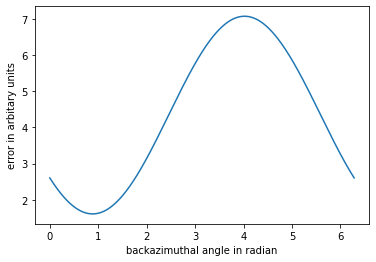

In [15]:
plt.plot(x,y)
plt.xlabel("backazimuthal angle in radian")
plt.ylabel("error in arbitary units")


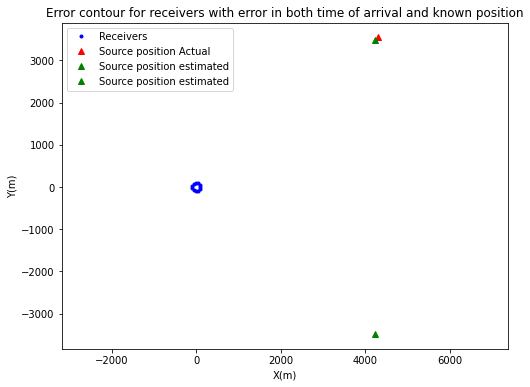

diff in location:  7023.442687906799


In [16]:
x,y =np.mgrid[-500:500:1000j,-500:500:1000j]  # a 2D grid for defining domain and evaluation of source position

rec_pos_modified = np.zeros_like(rec_pos_act)
rec_pos_modified[:] = rec_pos_act[:]  # Can modify later if required

plt.figure(figsize=(8,6))
plt.plot(rec_pos_mes[:,0],rec_pos_mes[:,1],'b.',label='Receivers')
plt.plot(src[0],src[1],'r^',label='Source position Actual')
d=v*t_Rec_real[0]
plt.plot(d*np.sin(phi_estimated),d*np.cos(phi_estimated),'g^',label='Source position estimated')

plt.plot(d*np.sin(np.pi-phi_estimated),d*np.cos(np.pi-phi_estimated),'g^',label='Source position estimated')
#plt.plot(d*np.sin(np.pi/2-phi_estimated),d*np.cos(np.pi/2-phi_estimated),'g^',label='Source position estimated')
plt.plot()
plt.legend()
#plt.xlim(-500,500)
#plt.ylim(-500,500)
plt.xlabel('X(m)')
plt.ylabel('Y(m)')
plt.axis('equal')

plt.title('Error contour for receivers with error in both time of arrival and known position')
plt.show()

     

Cause of the error is because the estimated position assumes that first receiver (at index 0) is at origin ,\\
whereas this is not the case for circular configuration

Configurations tried so far:
linear,
gaussian(negative results),
circular

Noise introduced in position has standard deviation 5m; and that in time has standard deviation 5/v

ValueError: non-integer arg 1 for randrange()